# Titanic: Machine Learning from Disaster

## Import libraries

In [1678]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

## The Data

Let's start by reading in the titanic file into a pandas dataframe

In [1680]:
train=pd.read_csv('titanic_train.csv')
test=pd.read_csv('titanic_test.csv')

## Outliers Detection
Outliers detection:The Tukey Outlier detection model leverages the interquartile range in order to detect outliers.
This method is independence of the mean and standard deviation(or variance).
In addition,it is not influenced by extreme values in the data set

In [1681]:
def Outliers(df,m,columns,factor):
    outlier_indices=[]
    for column in columns:
        IQR=np.percentile(df[column],75)-np.percentile(df[column],25)
        outlier_step=factor*IQR
        outlier_list_col=df[(df[column]<np.percentile(df[column],25)-outlier_step)|(df[column]>np.percentile(df[column],75)+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices=Counter(outlier_indices)        
    multiple_outliers=[k for k,v in outlier_indices.items() if v>m]
    return multiple_outliers

Only columns 'Age','SibSp','Parch','Fare' can detect outliers since they are numeric

In [1682]:
Outliers_to_drop=Outliers(train,2,["Age","SibSp","Parch","Fare"],1.5)

C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [1683]:
train.iloc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [1684]:
train=train.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

## Handling missing data

Feature:Age,Cabin,Embarked,Fare and Survived exist missing value

In [1686]:
train.drop(['Cabin','PassengerId','Name','Ticket'],axis=1,inplace=True)
train=train.dropna()

In [1687]:
train_len=len(train)

In [1688]:
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [1689]:
test.drop(['Cabin','PassengerId','Name','Ticket'],axis=1,inplace=True)

In [1690]:
test=test.dropna()

In [1691]:
test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Concate Train and Test dataset together

In [1692]:
data=pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

In [1693]:
data.isnull().sum()

Age           0
Embarked      0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    331
dtype: int64

Now no missing value in train and test dataset.

## Exploratory Data Analysis

Correlation matrix

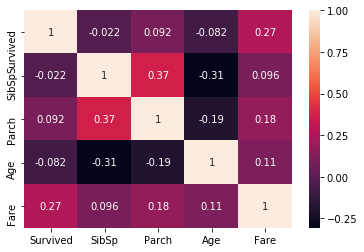

In [1694]:
sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True)

Most of features do not have significant correlation except (SibSp-Parch and SibSp-Age)

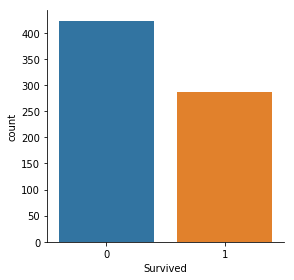

In [1695]:
sns.factorplot(x='Survived',data=train,kind='count')

More than 400 people don't survived and less than 300 people survived

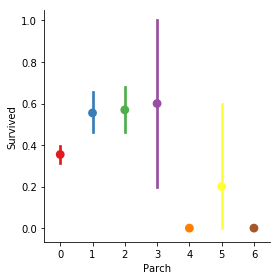

In [1696]:
parch=sns.factorplot(x='Parch',y='Survived',data=train,palette='Set1')

It shows that Parch=3 have the highest chance to survive

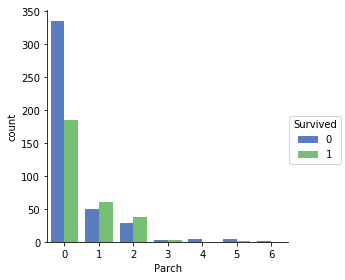

In [1697]:
sns.factorplot(x='Parch',data=train,kind='count',hue='Survived',palette='muted')

Most of Passengers don't abord parents / children

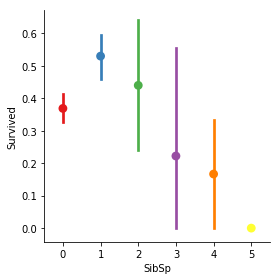

In [1698]:
sibsp=sns.factorplot(x="SibSp",y="Survived",data=train,palette='Set1')

It shows that SibSp=1 or 2 have higher chance to survive

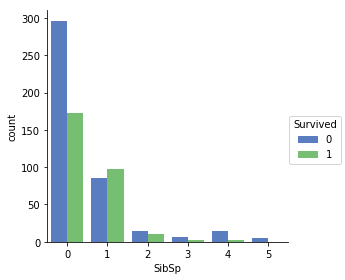

In [1699]:
sns.factorplot(x='SibSp',data=train,kind='count',hue='Survived',palette='muted')

Most of Passengers don't abord siblings / spouses

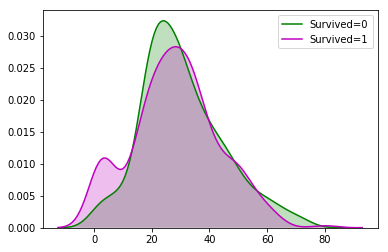

In [1700]:
g=sns.kdeplot(train["Age"][(train["Survived"] == 0)],color="g",shade=True)
g=sns.kdeplot(train["Age"][(train["Survived"] == 1)],color="m",shade=True)
g=g.legend(["Survived=0","Survived=1"])

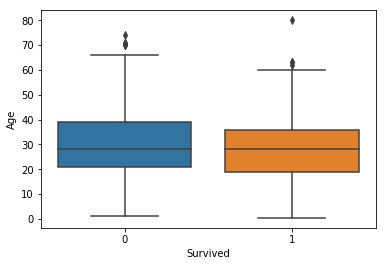

In [1701]:
sns.boxplot(x="Survived",y="Age",data=train)

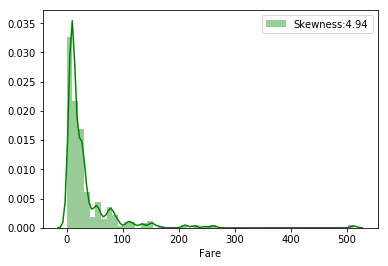

In [1702]:
g=sns.distplot(train['Fare'],color="g",label="Skewness:%.2f"%(train['Fare'].skew()))
g.legend()

Since feature 'Fare' is very skewed, we need to apply transformation in order to convert to normal distribution

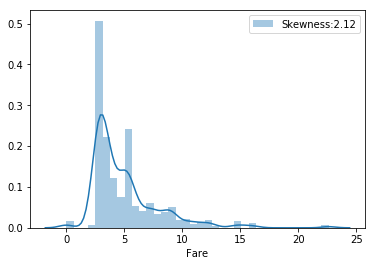

In [1703]:
g=sns.distplot(np.sqrt(train['Fare']),label="Skewness:%.2f"%(np.sqrt(train['Fare']).skew()))
g.legend()

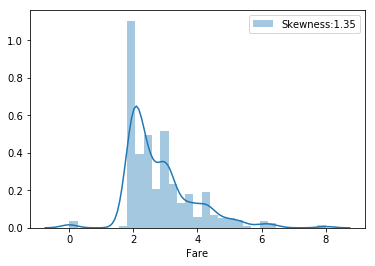

In [1704]:
g=sns.distplot((train['Fare']**(1/3)),label="Skewness:%.2f"%((train['Fare']**(1/3)).skew()))
g.legend()

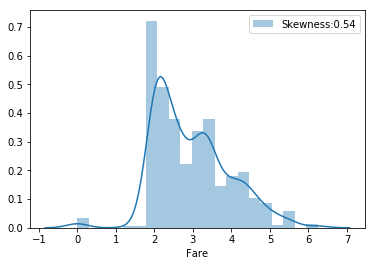

In [1705]:
q=train['Fare'].map(lambda j: np.log(j) if j > 0 else 0)
g=sns.distplot(q,label="Skewness:%.2f"%(q.skew()))
g.legend()

We compare 3 transformation methods, log, sqare-roots and cube-roots. Log transformation is less skewed

In [1706]:
data["Fare"]=data["Fare"].map(lambda j: np.log(j) if j > 0 else 0)

In [1707]:
train["Fare"]=train["Fare"].map(lambda j: np.log(j) if j > 0 else 0)

In [1708]:
test["Fare"]=test["Fare"].map(lambda j: np.log(j) if j > 0 else 0)

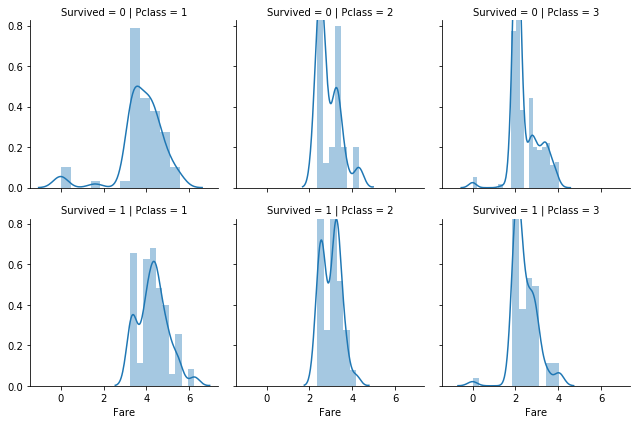

In [1709]:
g = sns.FacetGrid(train, col='Pclass', row='Survived')
g = g.map(sns.distplot,'Fare')

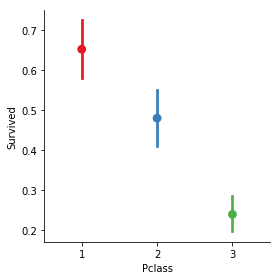

In [1710]:
sns.factorplot(x="Pclass",y="Survived",data=train,palette='Set1')

First class passengers have the highest survived probabilty

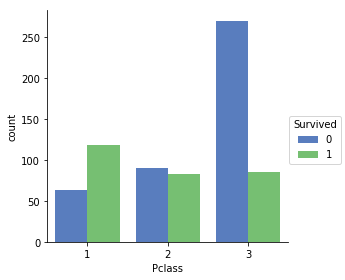

In [1711]:
sns.factorplot(x="Pclass",data=train,kind='count',hue='Survived',palette='muted')

Most of the passengers belong to class 3

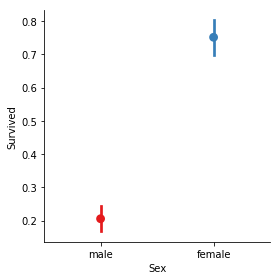

In [1712]:
sns.factorplot(x="Sex",y="Survived",data=train,palette='Set1')

Obviously, Male have less chance to survive than Female

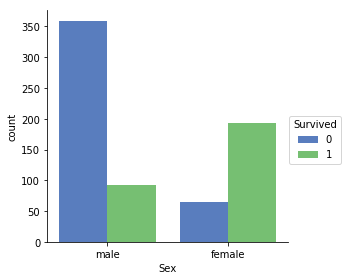

In [1713]:
sns.factorplot(x="Sex",data=train,kind='count',hue='Survived',palette='muted')

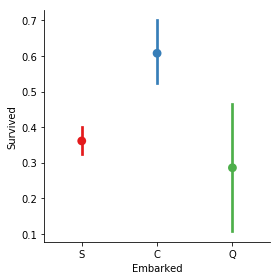

In [1714]:
sns.factorplot(x="Embarked",y="Survived",data=train,palette='Set1')

Embarkation from Cherbourg have higher chance to survive

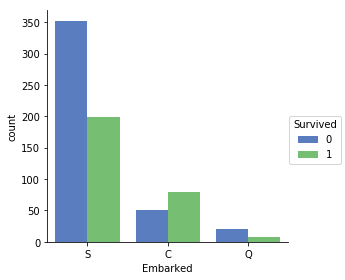

In [1715]:
sns.factorplot(x="Embarked",data=train,kind='count',hue='Survived',palette='muted')

Most of passengers Embark from Southampton

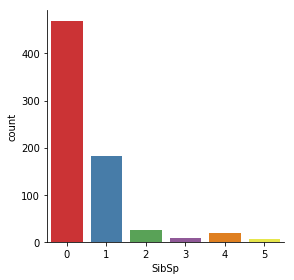

In [1716]:
sibsp=sns.factorplot(x="SibSp",kind='count',data=train,palette='Set1')

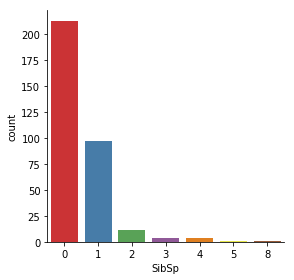

In [1717]:
sibsp=sns.factorplot(x="SibSp",kind='count',data=test,palette='Set1')

## Converting Categorical Features

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [1718]:
for i in ['Sex','SibSp','Parch','Embarked','Pclass']:
    data=pd.get_dummies(data,columns=[i],prefix=i)

## Split dataset 'data' into train and test dataset

In [1613]:
train=data[:train_len]

In [1614]:
test=data[train_len:]

In [1615]:
Y_train=train['Survived']

In [1616]:
X_train=train.drop(['Survived'],axis=1)

In [1617]:
X_test=test.drop(['Survived'],axis=1)

## Machine Learning Models

Feature 'Survived' do not exist in testing dataset, therefore the performance cannot be evaluated.
We need to split training dataset.

In [1619]:
X_tr, X_te, y_tr, y_te=train_test_split(X_train,Y_train,test_size=0.30,random_state=101)

## Logistics regession

In [1621]:
logmodel.fit(X_tr,y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [1622]:
predictions=logmodel.predict(X_te)

In [1623]:
print(classification_report(y_te,predictions))

             precision    recall  f1-score   support

        0.0       0.81      0.87      0.84       125
        1.0       0.80      0.72      0.75        88

avg / total       0.81      0.81      0.81       213



## Support Vector Machine 

In [1625]:
model=SVC()

In [1626]:
model.fit(X_tr,y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1627]:
predictions_svc = model.predict(X_te)

In [1628]:
print(classification_report(y_te,predictions))

             precision    recall  f1-score   support

        0.0       0.81      0.87      0.84       125
        1.0       0.80      0.72      0.75        88

avg / total       0.81      0.81      0.81       213



## Suppor Vector Machine with Grid Search

In [1630]:
kfold = StratifiedKFold(n_splits=10)

In [1631]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [1632]:
kfold = StratifiedKFold(n_splits=10)

In [1633]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [1634]:
grid.fit(X_tr,y_tr)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6024096385542169, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ............ C=0.1, gamma=1, kernel=rbf, score=0.6, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ............ C=0.1, gamma=1, kernel=rbf, score=0.6, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.6024096385542169, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .......... C=0.1, gamma=0.1, kernel=rbf, score=0.6, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .......... C=0.1, gamma=0.1, kernel=rbf, score=0.6, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV]  C=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1, gamma=1, kernel=rbf, score=0.7289156626506024, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=1, gamma=1, kernel=rbf, score=0.6787878787878788, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV]  C=1, gamma=1, kernel=rbf, score=0.6606060606060606, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.7409638554216867, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ............ C=1, gamma=0.1, kernel=rbf, score=0.8, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV]  C=1, gamma=0.1, kernel=rbf, score=0.8181818181818182, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV]  C=1, gamma=0.01, kernel=rbf, score=0.7469879518072289, total=   0.0s
[CV] C=1, gamma=0.01, kernel=rbf ...............................

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [1635]:
grid.best_score_

0.82459677419354838

In [1636]:
grid_predictions = grid.predict(X_te)

In [1637]:
print(classification_report(y_te,grid_predictions))

             precision    recall  f1-score   support

        0.0       0.81      0.88      0.84       125
        1.0       0.81      0.70      0.75        88

avg / total       0.81      0.81      0.81       213



## Random forest

In [1639]:
rfc = RandomForestClassifier(n_estimators=100)

In [1640]:
rfc.fit(X_tr,y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1641]:
rfc_pred = rfc.predict(X_te)

In [1642]:
print(classification_report(y_te,rfc_pred))

             precision    recall  f1-score   support

        0.0       0.83      0.80      0.81       125
        1.0       0.73      0.76      0.74        88

avg / total       0.79      0.78      0.78       213



## Random forest with Grid Search 

In [1643]:
kfold = StratifiedKFold(n_splits=10)

In [1644]:
rf_param_grid={"max_depth": [None],"max_features": [1, 3, 10],"min_samples_split": [2, 3, 10],"min_samples_leaf": [1, 3, 10],"bootstrap": [False],"n_estimators" :[100,300],"criterion": ["gini"]}

In [1645]:
gsRFC=GridSearchCV(rfc,param_grid=rf_param_grid,cv=kfold,scoring="accuracy",n_jobs= 4,verbose = 1)

In [1646]:
gsRFC.fit(X_tr,y_tr)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   42.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [False], 'n_estimators': [100, 300], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [1647]:
gsRFC.best_score_

0.82056451612903225

In [1648]:
grid_predictions_RFC = gsRFC.predict(X_te)

In [1649]:
print(classification_report(y_te,grid_predictions_RFC))

             precision    recall  f1-score   support

        0.0       0.78      0.89      0.83       125
        1.0       0.80      0.65      0.72        88

avg / total       0.79      0.79      0.78       213



## AdaBoostClassifier with Grid Search 

In [1652]:
dtc=DecisionTreeClassifier()

In [1653]:
abc=AdaBoostClassifier(dtc,n_estimators=100)

In [1654]:
kfold = StratifiedKFold(n_splits=10)

In [1655]:
ada_param_grid={"base_estimator__criterion" : ["gini", "entropy"],"base_estimator__splitter" :   ["best", "random"],"algorithm" : ["SAMME","SAMME.R"],"n_estimators" :[1,2],"learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

In [1656]:
gsadaDTC=GridSearchCV(abc,param_grid=ada_param_grid,cv=kfold,scoring="accuracy",n_jobs= 4,verbose = 1)

In [1657]:
gsadaDTC.fit(X_tr,y_tr)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    6.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'], 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1, 2], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [1658]:
gsadaDTC.best_score_

0.79032258064516125

In [1659]:
grid_predictions_DTC=gsadaDTC.predict(X_te)

In [1660]:
print(classification_report(y_te,grid_predictions_DTC))

             precision    recall  f1-score   support

        0.0       0.77      0.84      0.80       125
        1.0       0.74      0.65      0.69        88

avg / total       0.76      0.76      0.76       213



## Gradient boosting with Grid Search 

In [1662]:
kfold = StratifiedKFold(n_splits=10)

In [1663]:
gbc=GradientBoostingClassifier()

In [1664]:
gb_param_grid={'loss' : ["deviance"],'n_estimators' : [100,200,300],'learning_rate': [0.1, 0.05, 0.01],'max_depth': [4, 8],'min_samples_leaf': [100,150],'max_features': [0.3, 0.1] }

In [1665]:
gsGBC=GridSearchCV(gbc,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

In [1666]:
gsGBC.fit(X_tr,y_tr)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 626 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   16.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'loss': ['deviance'], 'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [4, 8], 'min_samples_leaf': [100, 150], 'max_features': [0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [1667]:
gsGBC.best_score_

0.81048387096774188

In [1668]:
grid_predictions_GBC=gsGBC.predict(X_te)

In [1669]:
print(classification_report(y_te,grid_predictions_GBC))

             precision    recall  f1-score   support

        0.0       0.78      0.90      0.84       125
        1.0       0.83      0.65      0.73        88

avg / total       0.80      0.80      0.79       213



### Compare to classification report. Suppor Vector Machine with Grid Search and Logistics regession have the best performance